山の数OK


In [99]:
# command to view figures in Jupyter notebook
%matplotlib inline 

# import plotting module 
import matplotlib.pyplot as plt 

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18   # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 20   # fontsize for figure titles
plt.rcParams['font.size'] = 16        # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.6 # line width for plotting

In [100]:
# import modules
import math
import numpy as np
import scipy as sc
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt
import wave
import pandas as pd

In [101]:
def EMG(file):
    # file open 各自で修正
    record = pd.read_csv(file, delim_whitespace=False, skiprows=None, header=None)
    waveData = record[0]    
    sampleRate = 1000
        
    # calculate time window
    timeEMG=np.linspace(0, len(waveData)/sampleRate, num=len(waveData))
    
    # calculate frequency
    freq = 1/np.mean(np.diff(timeEMG))    
    
    # save relevant data in array
    xx={'sampleRate':sampleRate,\
        'waveData':waveData,\
        'timeEMG':timeEMG,\
        'freq':freq,\
    }  
    
    # plot EMG
    plt.figure(figsize=(18,6))
    plt.xlabel(r'time (s)')
    plt.ylabel(r'voltage ($\mu$V)')
    plt.plot(xx['timeEMG'],xx['waveData'], 'b')
    plt.xlim(0,max(xx['timeEMG']));
    
    return xx

/var/folders/4g/bbm0gjv155936xsdg_41_4080000gn/T/ipykernel_36796/413346002.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  record = pd.read_csv(file, delim_whitespace=False, skiprows=None, header=None)


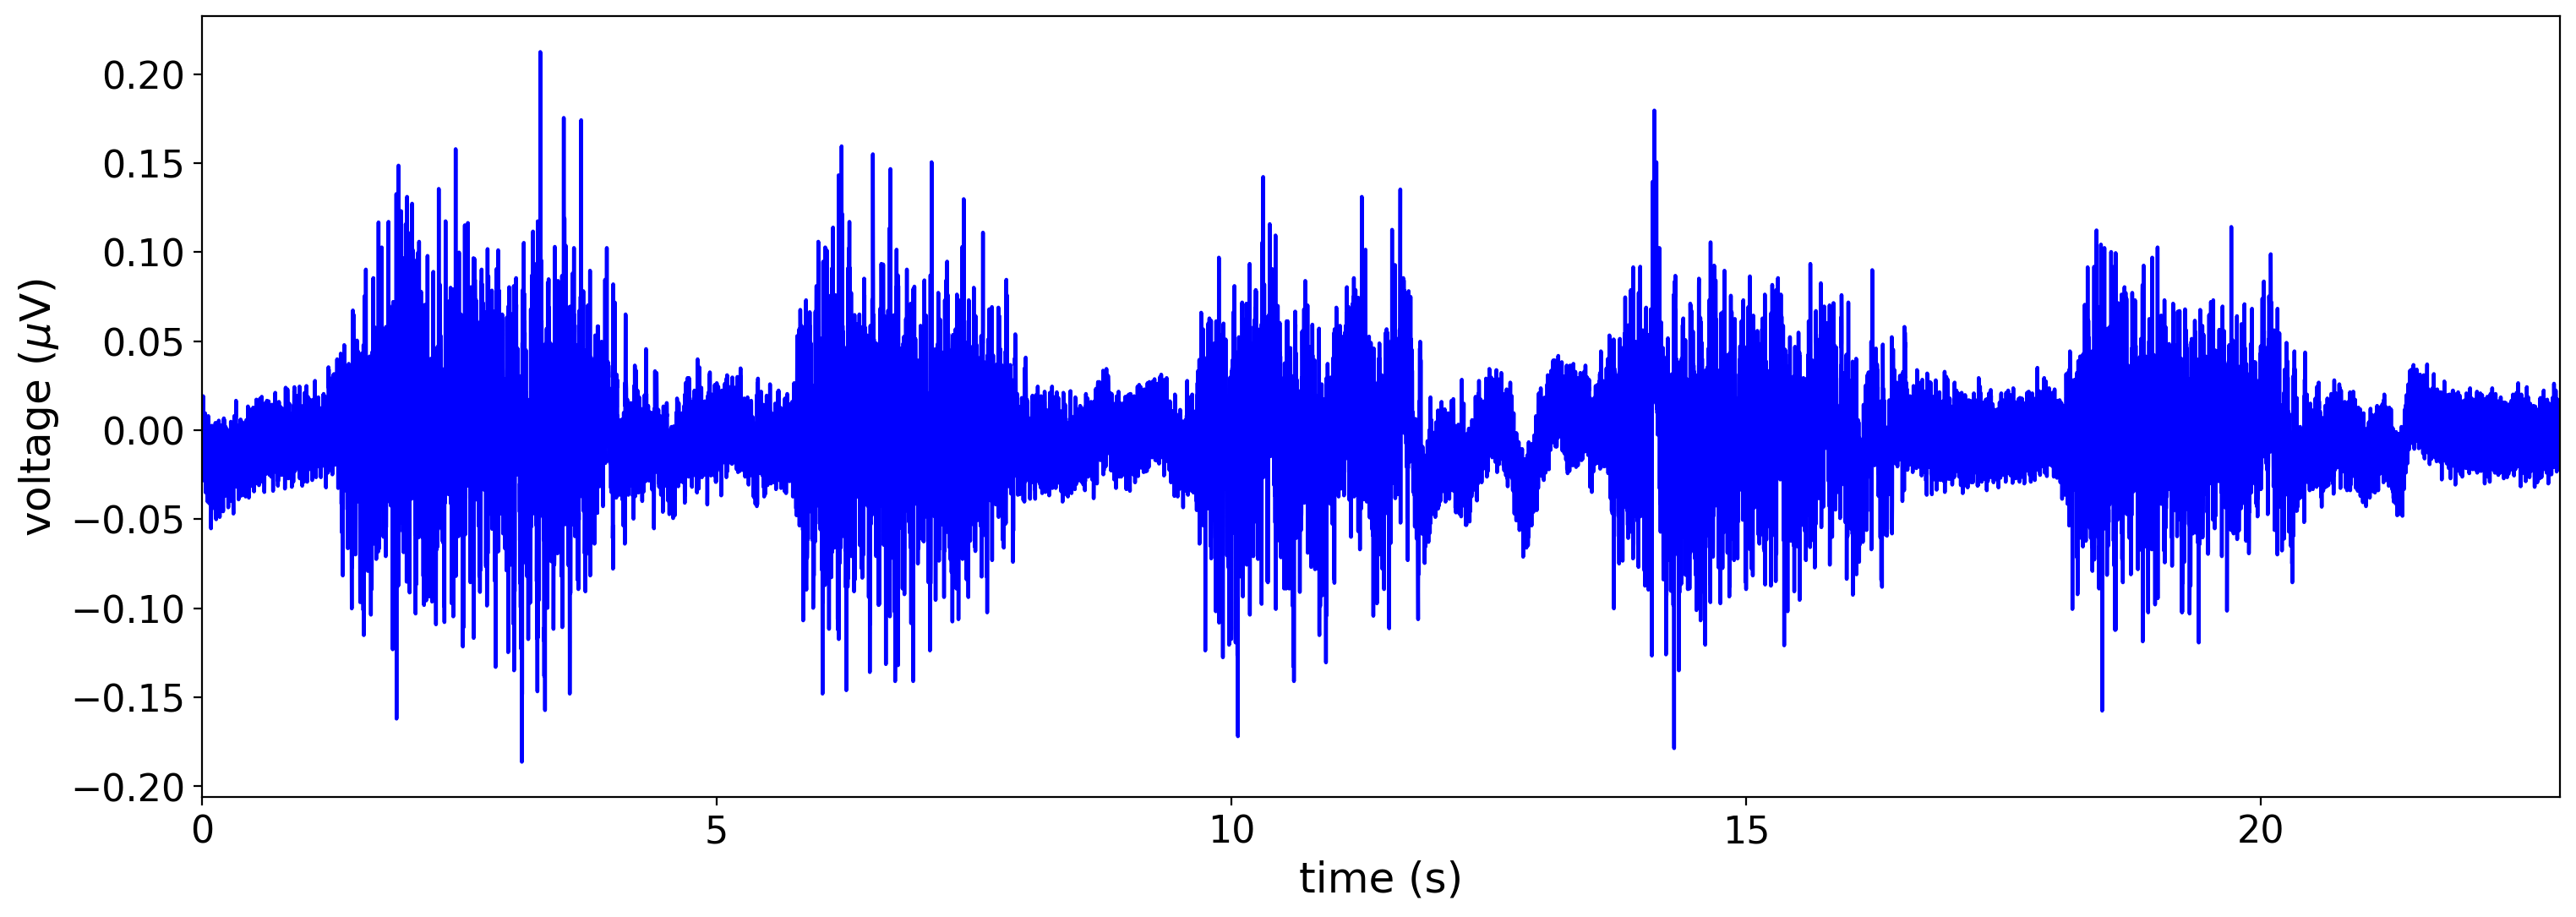

In [102]:
file_name = "data/problem3/IEMG_20kg_goto_data_20241121_144825.csv"
xx = EMG(file=file_name)

In [103]:
# band-pass Butterworth filter at 10-400Hz
b, a = butter(2, ([10, 400]/(xx['freq']/2)), btype = 'bandpass')
dataf = filtfilt(b, a, xx['waveData'])

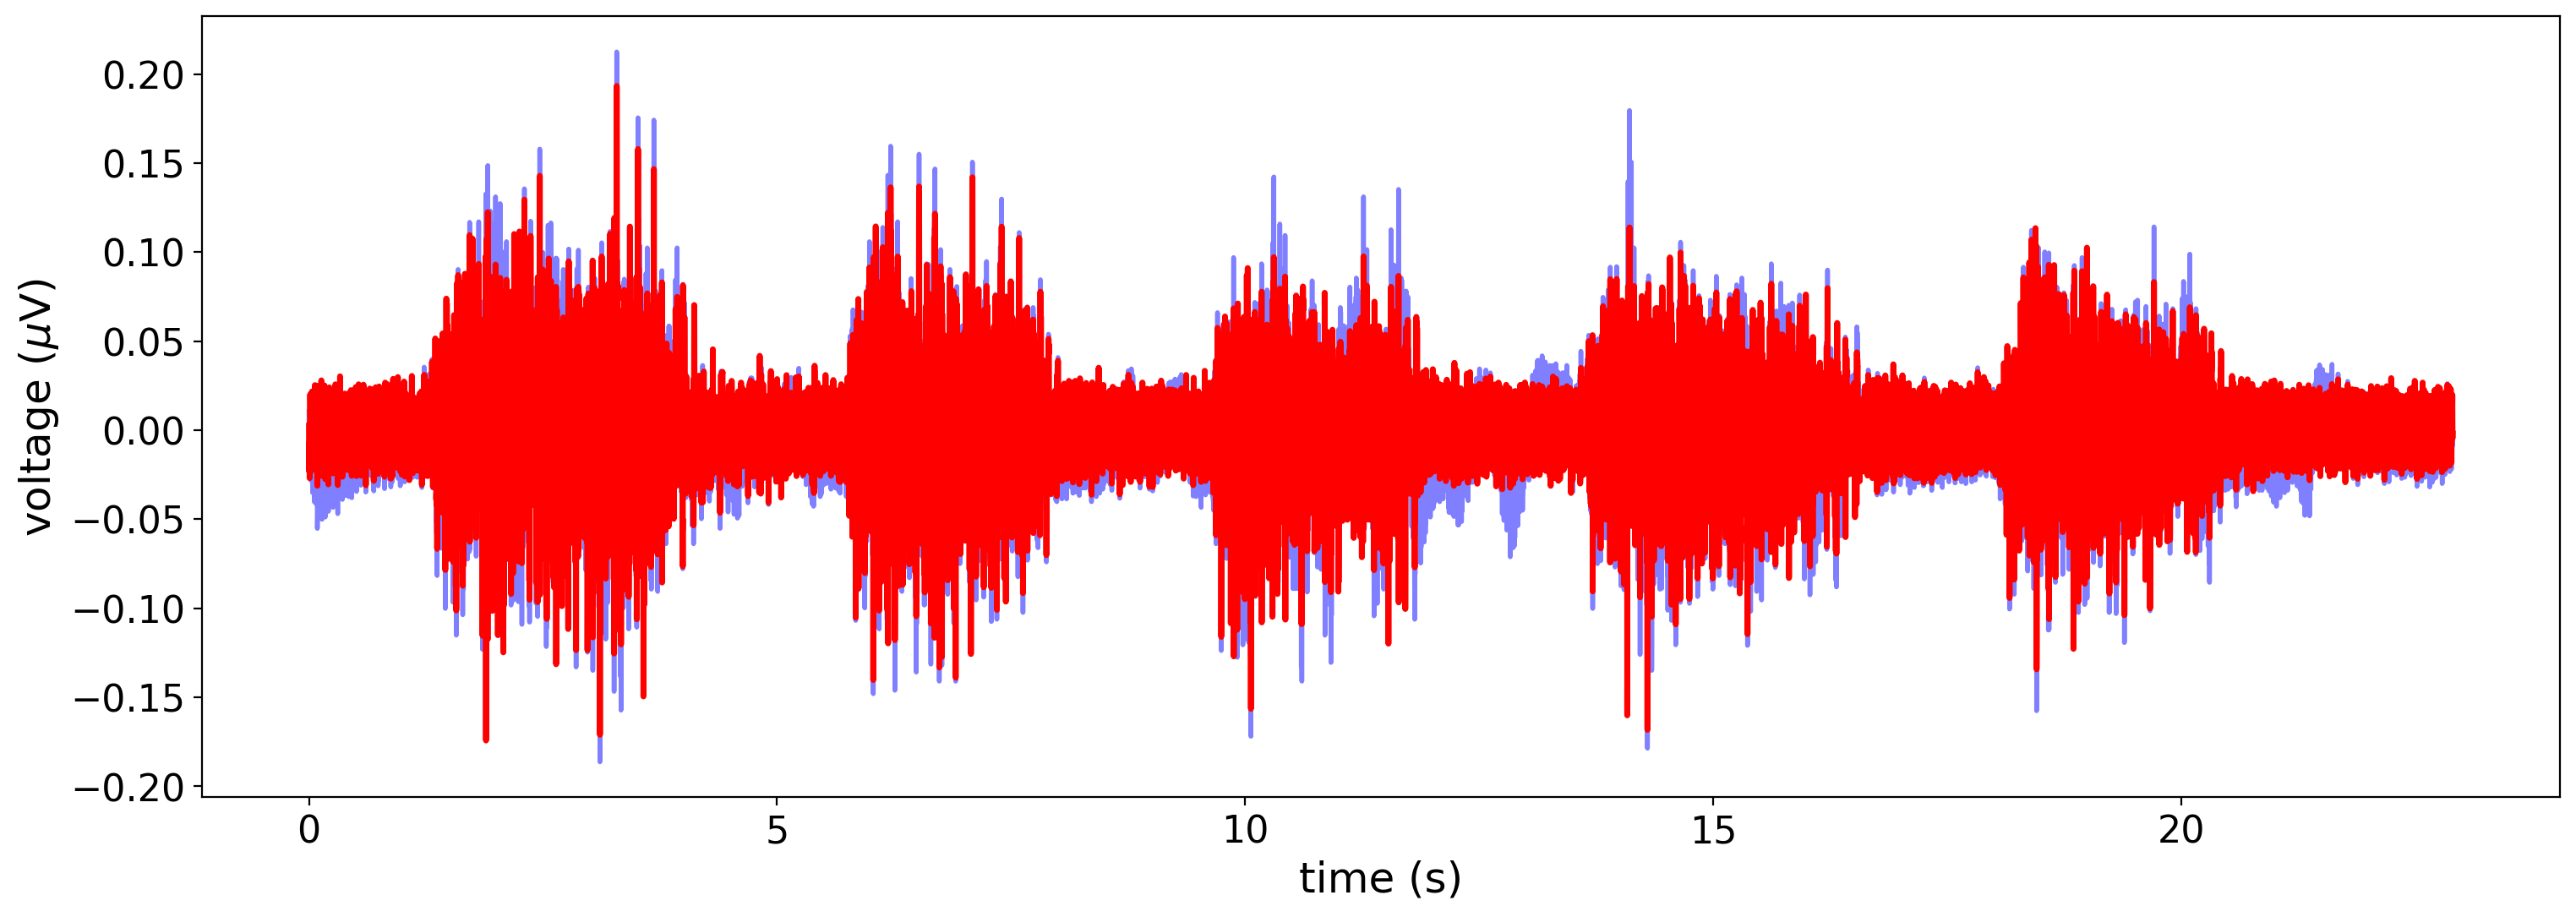

In [104]:
# plot EMG signal
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(xx['timeEMG'],xx['waveData'], 'b', linewidth=2.0, alpha=0.5)
plt.plot(xx['timeEMG'],dataf, 'r', linewidth=2.5)
#plt.xlim(2.1,2.2)
#plt.ylim(-10000,3000);

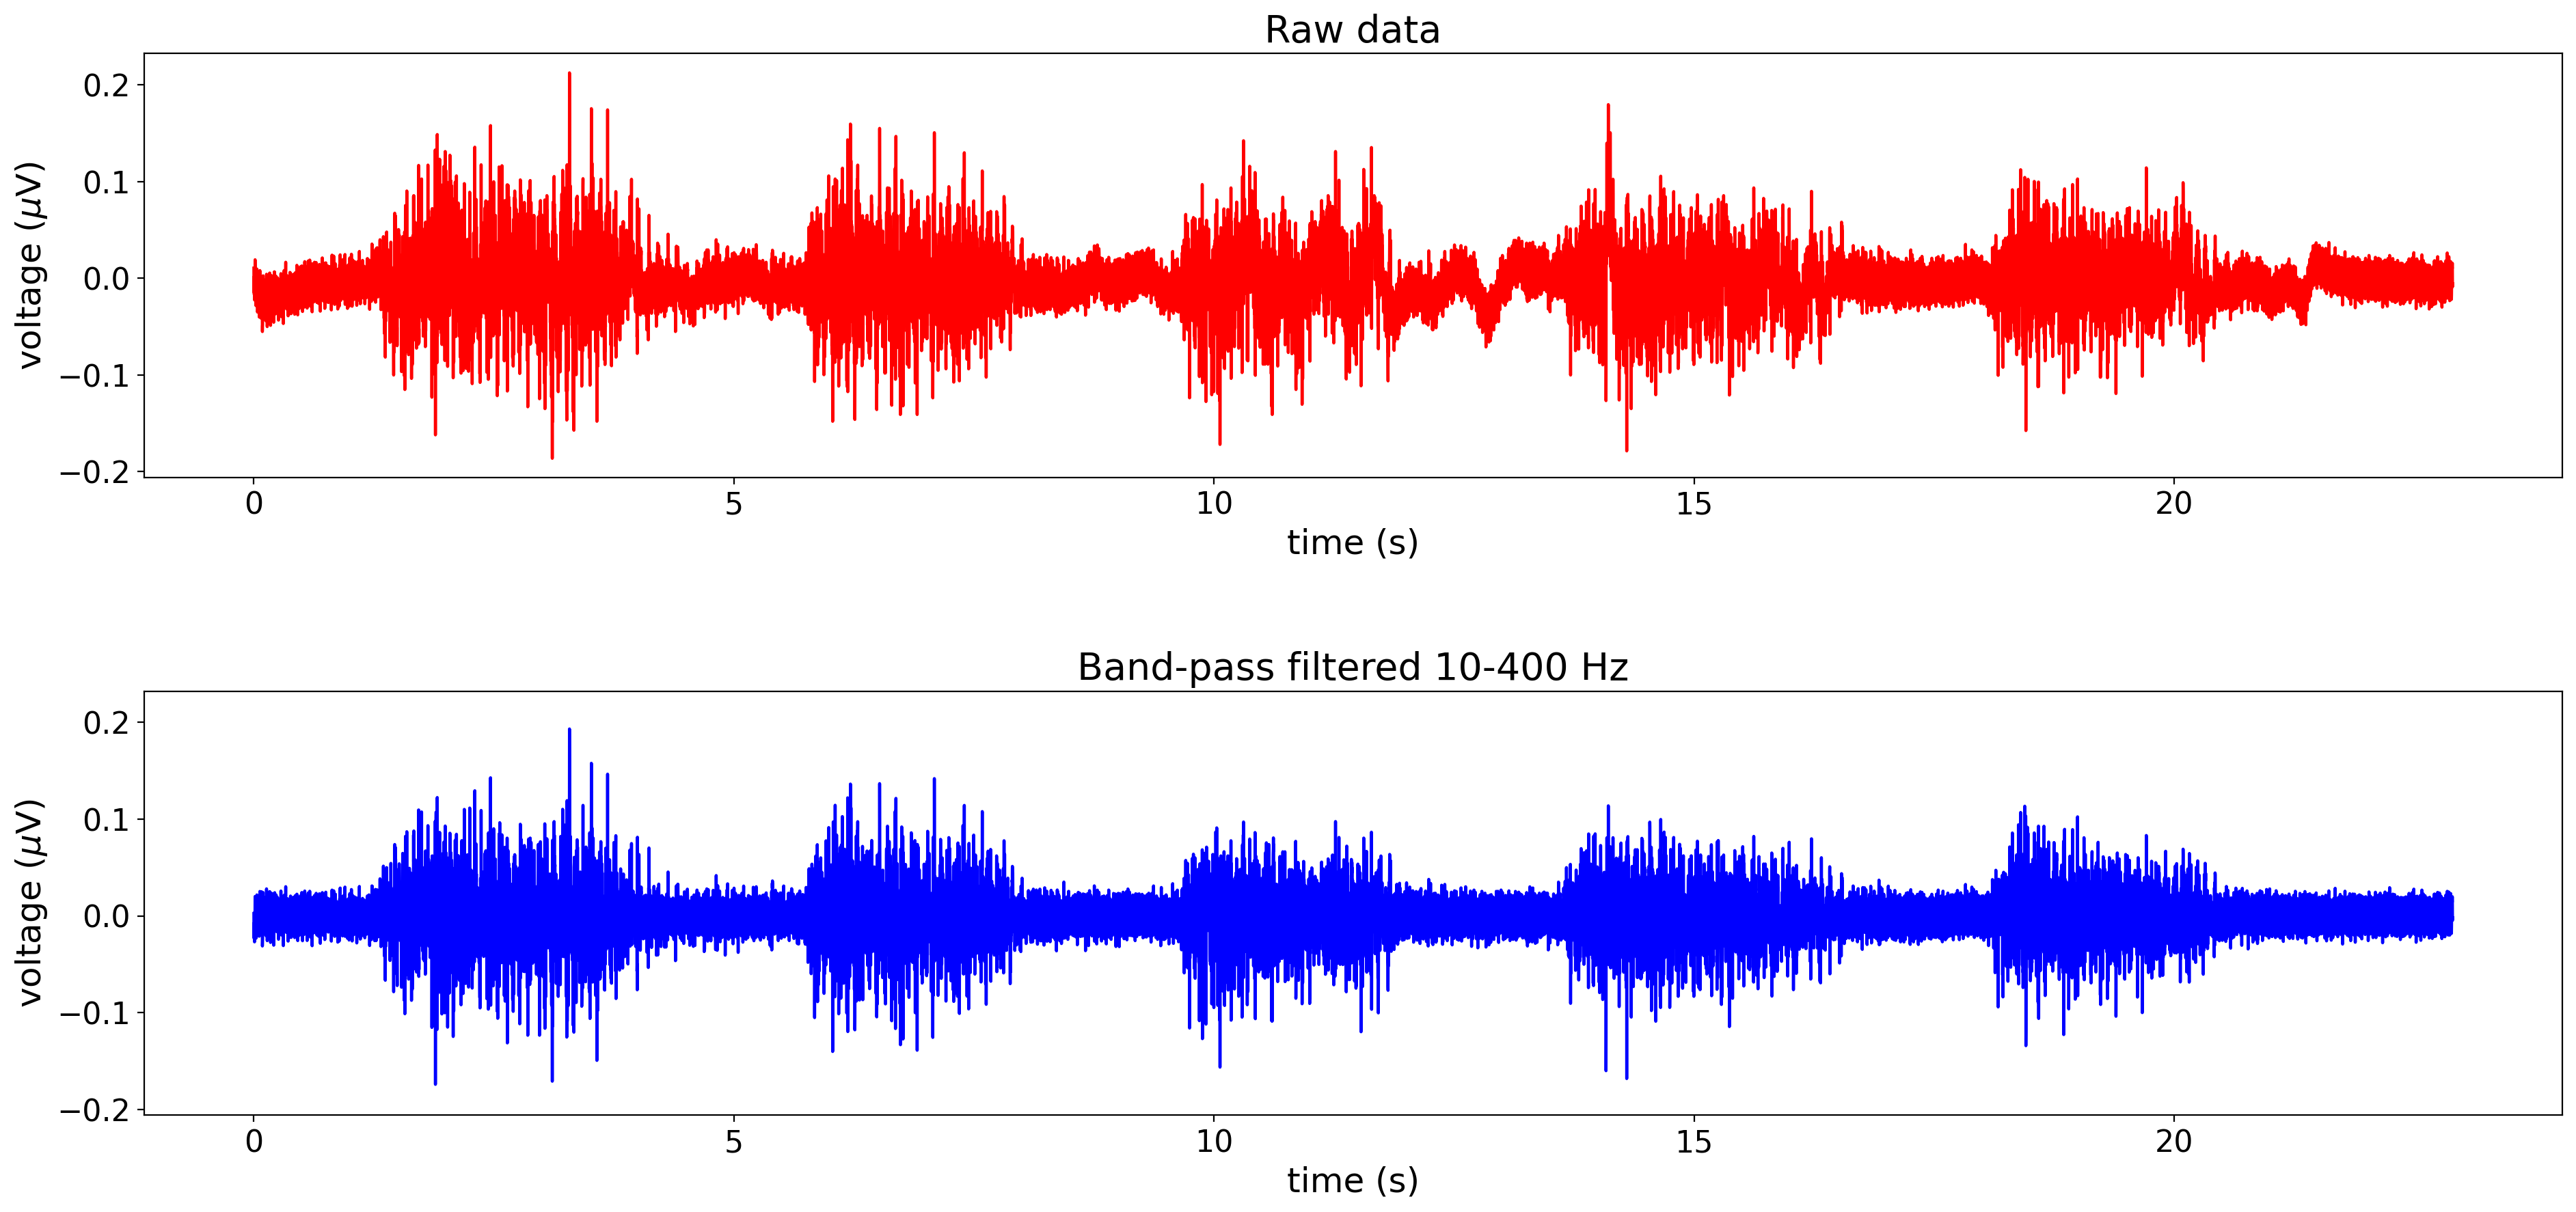

In [105]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex= False, sharey= True, figsize = (20,10))

# plot raw data
ax1.plot(xx['timeEMG'], xx['waveData'], 'r')
ax1.set_title('Raw data', fontsize=20)
#ax1.set_xlim(3.0,3.5)
#ax1.set_ylim(-8000,3500)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('voltage ($\mu$V)')

# plot filtered data
ax2.plot(xx['timeEMG'], dataf, 'b')
ax2.set_title('Band-pass filtered 10-400 Hz', fontsize=20)
#ax2.set_xlim(3.0,3.5)
#ax2.set_ylim(-8000,3500)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('voltage ($\mu$V)')

# spacing between subplots
plt.tight_layout(pad=3.0)

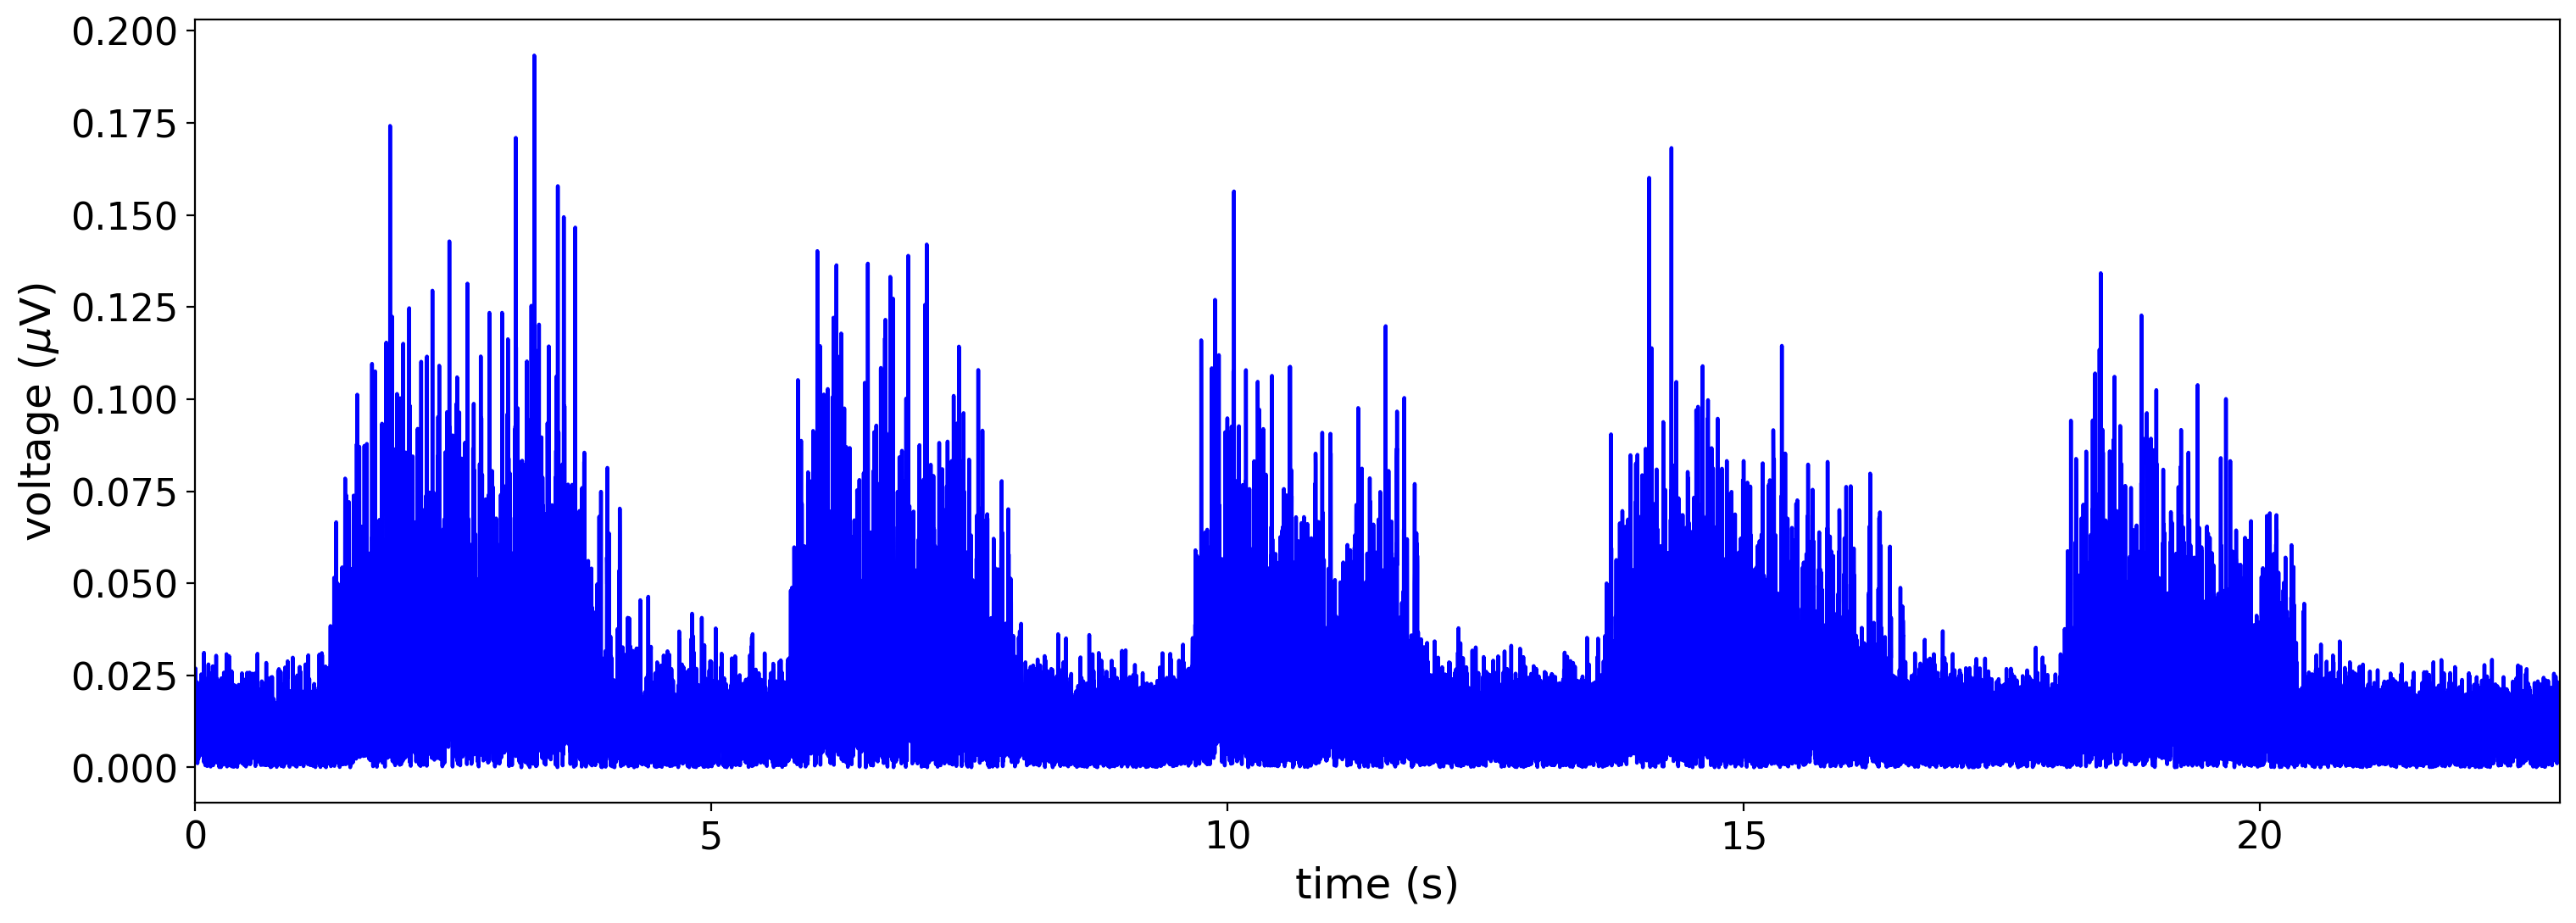

In [106]:
# rectify EMG signal
absSignal = np.absolute(dataf)
timeAbs=np.linspace(0, len(absSignal)/xx['sampleRate'], num=len(absSignal))

# plot rectified data
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(xx['timeEMG'],absSignal,'b')
plt.xlim(0,max(xx['timeEMG']))
#plt.ylim(-500,8000)
plt.show()

In [107]:
# low-pass Butterworth filter for envelope detection（包絡線の検出）
lowp = 8
sfreq = xx['sampleRate']
low_pass = lowp/sfreq
b, a = sc.signal.butter(4, low_pass, btype='lowpass')
datafrle = filtfilt(b, a, absSignal)

(0.0, 22.9)

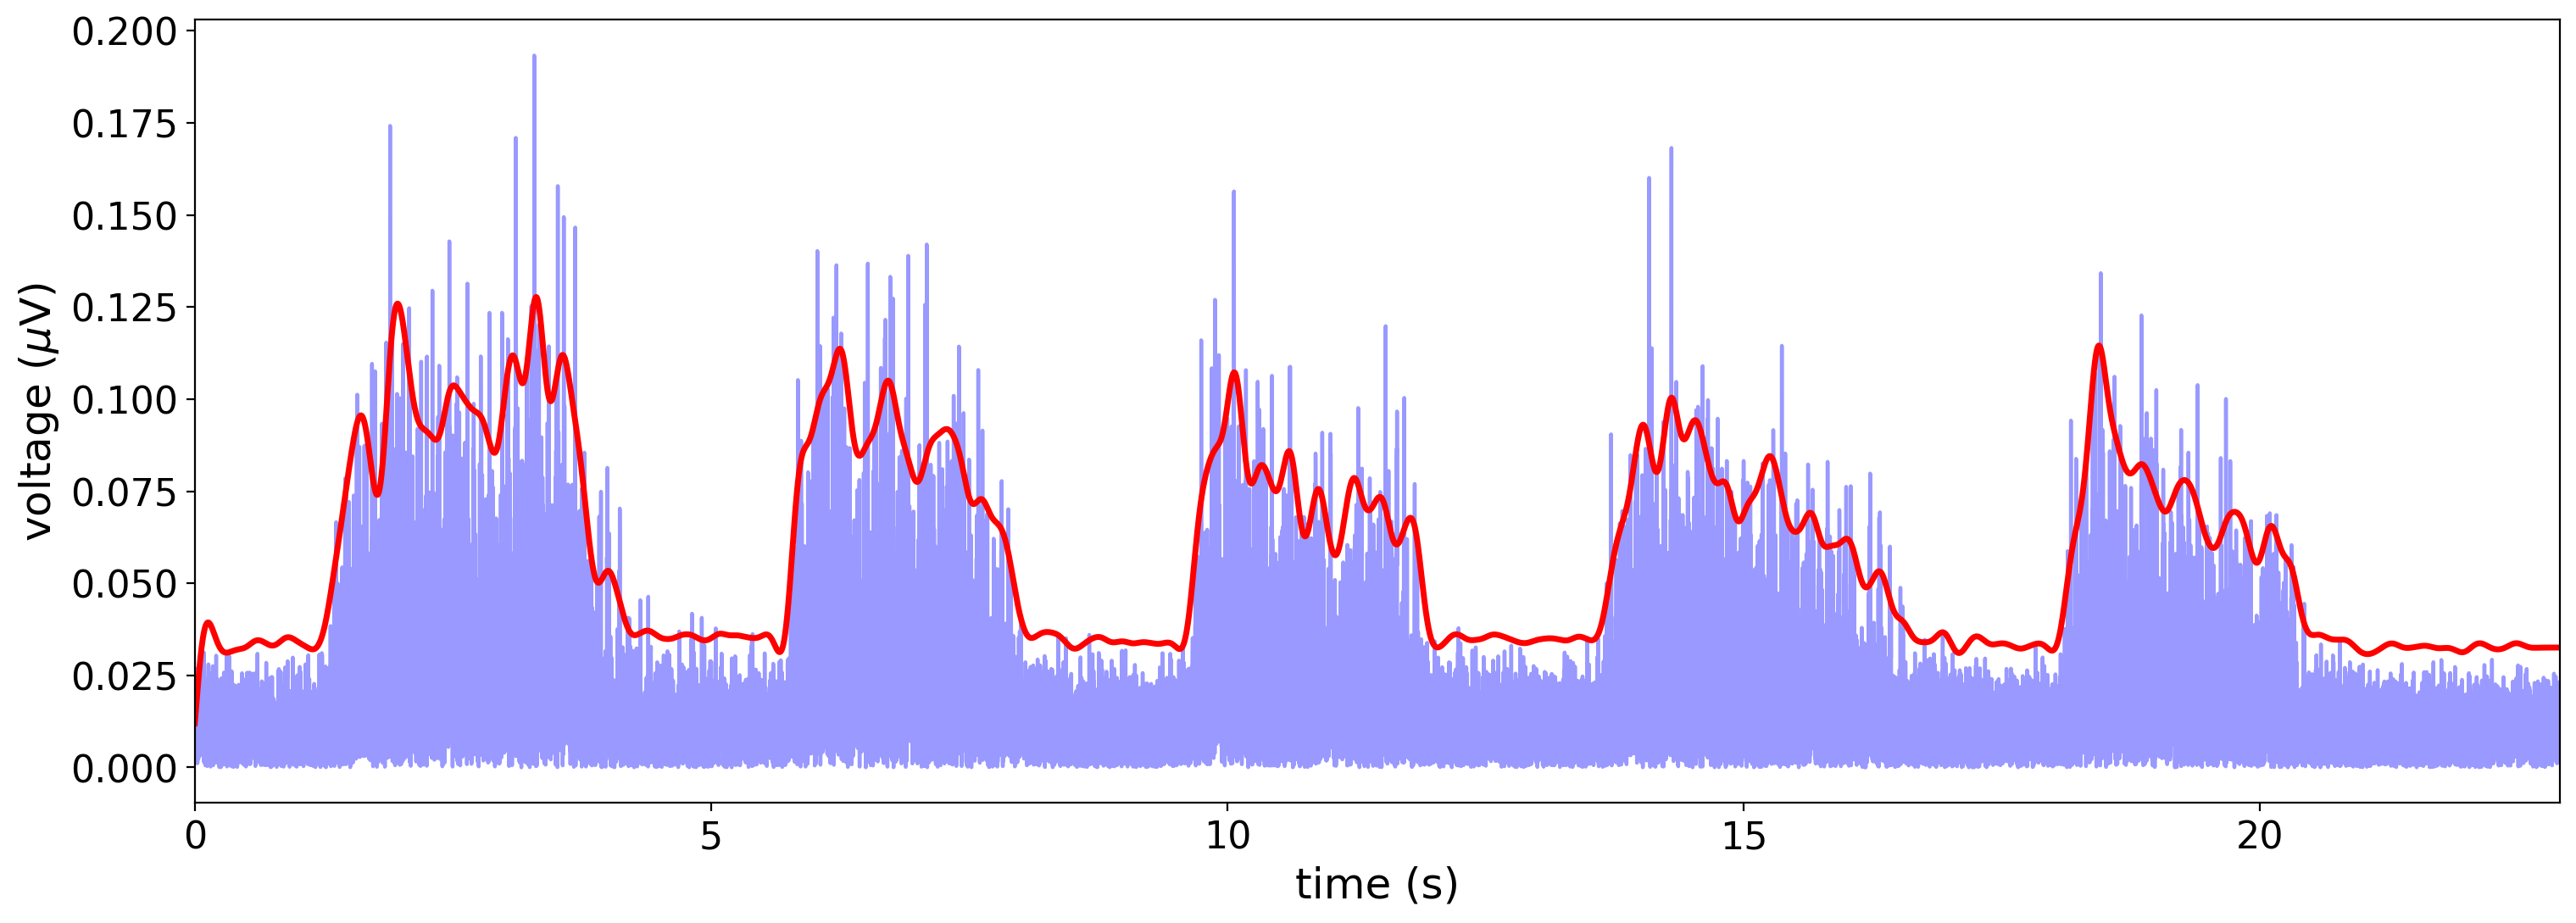

In [108]:
# plot rectified EMG signal with superimposed envelope detection with low-pass filter
plt.figure(figsize=(18,6))
plt.xlabel('time (s)')
plt.ylabel('voltage ($\mu$V)')
plt.plot(timeAbs,absSignal, 'b', alpha=0.4)
plt.plot(timeAbs,datafrle*3, 'r', linewidth=2.5) # multiply envelope to see data fit
plt.xlim(0,max(xx['timeEMG']))
#plt.ylim(-400,7500);

In [109]:
def contractions(threshold):
    
    # ascending threshold crossings 閾値の開始
    cstarts = []
    for i in range(1, len(datafrle)):
        if datafrle[i-1] < threshold and datafrle[i] >= threshold:
            cstarts.append(i)
    
    # descending threshold crossings 閾値の終了
    cstops = []
    for i in range(1, len(datafrle)):
        if datafrle[i-1] >= threshold and datafrle[i] < threshold:
            cstops.append(i)
    
    # divide start and stop times by the sampling rate to get times in seconds　開始・終了を時刻で表示
    starts=[]
    for n in range(0, len(cstarts)):
        starttime = cstarts[n]/xx['sampleRate']
        starts.append(starttime)

    stops=[]
    for n in range(0, len(cstops)):
        stoptime = cstops[n]/xx['sampleRate']
        stops.append(stoptime)    
    
    # plot envelope with contraction start and stop times marked by dashed lines
    plt.figure(figsize=(20,6))
    plt.xlabel('time (s)')
    plt.ylabel('voltage ($\mu$V)')
    plt.plot(timeAbs, datafrle, 'b', linewidth=2.0)      
    for n in range(0, len(starts)):
        plt.axvline(x=starts[n], color='k',linewidth=2.0, linestyle='--')
    for n in range(0, len(stops)):
        plt.axvline(x=stops[n], color='k',linewidth=2.0, linestyle='--')
    plt.xlim(0, max(xx['timeEMG']))
    
    # calculate contraction durations
    durs=[]
    for n in range(0,len(starts)):
        durs.append(stops[n]-starts[n])
        print('Contraction lasted %g seconds'%(round(durs[n], 2)))
        
    return

Contraction lasted 2.55 seconds
Contraction lasted 0.11 seconds
Contraction lasted 2.16 seconds
Contraction lasted 2.22 seconds
Contraction lasted 2.43 seconds
Contraction lasted 0.11 seconds
Contraction lasted 2.2 seconds


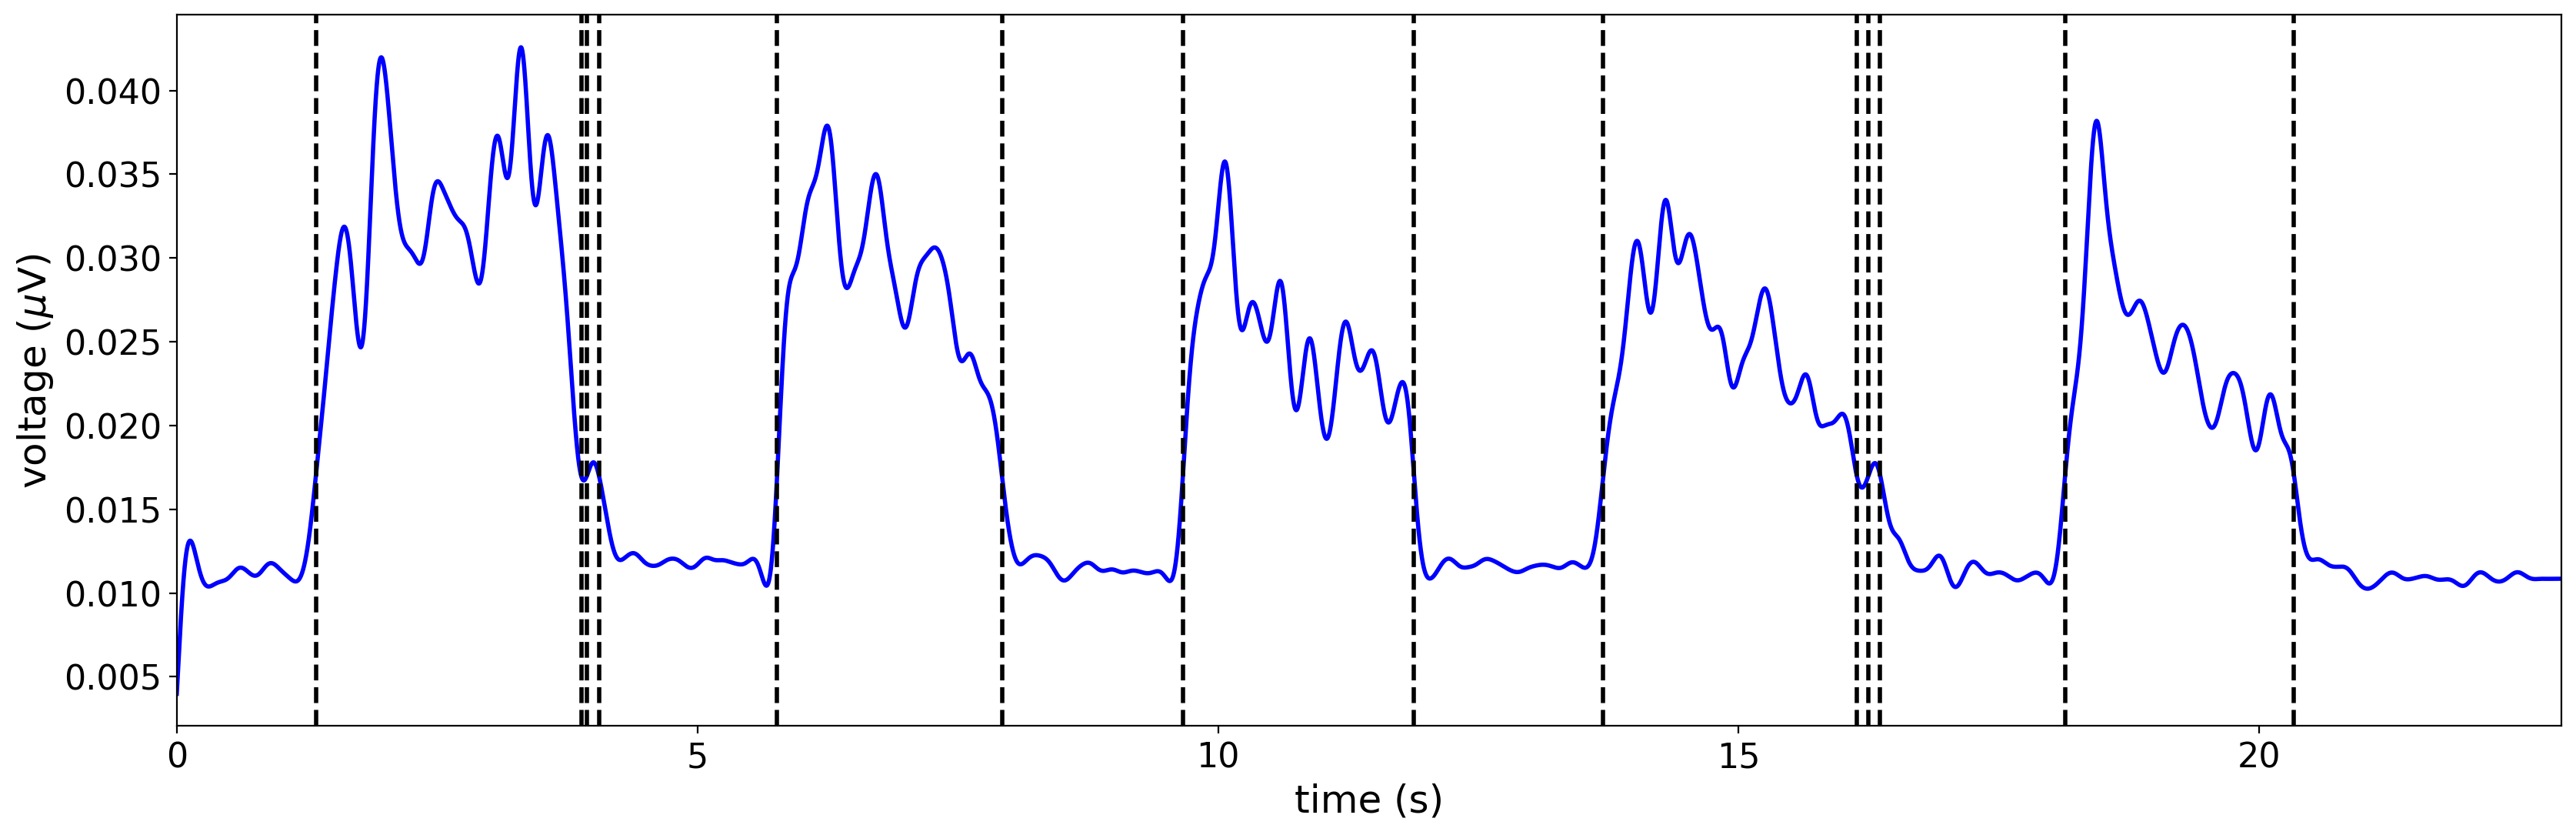

In [111]:
contractions(threshold=0.017) #閾値の設定: reportでは毎回このグラフを描くことはしない。